In [12]:
import pandas as pd 
import numpy as np

# Step 1: Load the DataFrames
systems_df = pd.read_csv('systems.csv')
sensors_df = pd.read_csv('sensors.csv')
measurements_df = pd.read_csv('measurements.csv')
control_actions_df = pd.read_csv('control_actions.csv')
signal_data_df = pd.read_csv('signal_data.csv')
signal_characteristics_df = pd.read_csv('signal_characteristics.csv')

# Step 2: Clean the data
def clean_data(df, df_name):
    print(f"Initial missing values in {df_name} DataFrame:")
    print(df.isnull().sum())
    
    if df_name == "SYSTEMS":
        # Interpolate missing system_id values
        if df['system_id'].isnull().any():
            df['system_id'] = df['system_id'].interpolate()
        
        # Use str.extract() to split the system_name into text and numeric parts
        split_names = df['system_name'].str.extract(r'(.+?)(\d+)$')
        df['text_part'] = split_names[0]
        df['num_part'] = pd.to_numeric(split_names[1], errors='coerce')

        # Interpolate the numeric part
        df['num_part'] = df['num_part'].interpolate()

        # Fill missing numeric parts with interpolated values and keep text parts intact
        for i in range(len(df)):
            if np.isnan(df['num_part'].iloc[i]) and np.isnan(df['system_id'].iloc[i]):
                # If both num_part and system_id are NaN, use the last known text and interpolate the number
                last_known_num = df['num_part'].ffill().iloc[i]
                df['num_part'].iloc[i] = last_known_num
        
        # Recombine the text and interpolated numeric parts
        df['system_name'] = df['text_part'] + ' ' + df['num_part'].fillna(0).astype(int).astype(str)

        # Drop temporary columns used for the operation
        df.drop(columns=['text_part', 'num_part'], inplace=True)
        

    # Confirm no missing values remain after specific cleaning
    print(f"Missing values after cleaning in {df_name} DataFrame:")
    print(df.isnull().sum())
    
    return df

# Clean the SYSTEMS DataFrame
systems_df = clean_data(systems_df, "SYSTEMS")
print(systems_df)

# Step 3: Check Data Types
def check_data_types(df):
    print(df.dtypes)

# Check data types for each DataFrame
print("Data types for SYSTEMS DataFrame:")
check_data_types(systems_df)

print("Data types for SENSORS DataFrame:")
check_data_types(sensors_df)

print("Data types for MEASUREMENTS DataFrame:")
check_data_types(measurements_df)

print("Data types for CONTROL_ACTIONS DataFrame:")
check_data_types(control_actions_df)

print("Data types for SIGNAL_DATA DataFrame:")
check_data_types(signal_data_df)

print("Data types for SIGNAL_CHARACTERISTICS DataFrame:")
check_data_types(signal_characteristics_df)

# Step 4: Convert Data Types if Necessary
def convert_data_types(df, df_name):
    # Convert system_id in SYSTEMS DataFrame
    if df_name == "SYSTEMS":
        df['system_id'] = df['system_id'].astype('Int64')  # Using Int64 for nullable integers
    # Convert timestamp columns to datetime
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    return df

# Convert data types for each DataFrame with names
systems_df = convert_data_types(systems_df, "SYSTEMS")
sensors_df = convert_data_types(sensors_df, "SENSORS")
measurements_df = convert_data_types(measurements_df, "MEASUREMENTS")
control_actions_df = convert_data_types(control_actions_df, "CONTROL_ACTIONS")
signal_data_df = convert_data_types(signal_data_df, "SIGNAL_DATA")
signal_characteristics_df = convert_data_types(signal_characteristics_df, "SIGNAL_CHARACTERISTICS")

# Check final data types
print("Final data types for SYSTEMS DataFrame:")
check_data_types(systems_df)
print("Final data types for SENSORS DataFrame:")
check_data_types(sensors_df)
print("Final data types for MEASUREMENTS DataFrame:")
check_data_types(measurements_df)
print("Final data types for CONTROL_ACTIONS DataFrame:")
check_data_types(control_actions_df)
print("Final data types for SIGNAL_DATA DataFrame:")
check_data_types(signal_data_df)
print("Final data types for SIGNAL_CHARACTERISTICS DataFrame:")
check_data_types(signal_characteristics_df)


Initial missing values in SYSTEMS DataFrame:
system_id      1
system_name    1
system_type    0
description    0
dtype: int64
Missing values after cleaning in SYSTEMS DataFrame:
system_id      0
system_name    1
system_type    0
description    0
dtype: int64
    system_id                  system_name       system_type  \
0         1.0   Advanced Control System  1       Fuzzy Logic   
1         2.0   Advanced Control System  2               PID   
2         3.0   Advanced Control System  3       Fuzzy Logic   
3         4.0   Advanced Control System  4          Adaptive   
4         5.0   Advanced Control System  5               PID   
5         6.0   Advanced Control System  6      Sliding Mode   
6         7.0   Advanced Control System  7               PID   
7         8.0   Advanced Control System  8               PID   
8         9.0   Advanced Control System  9               PID   
9        10.0  Advanced Control System  10       Fuzzy Logic   
10       11.0  Advanced Control Syste

In [13]:
def get_sensor_statistics(sensor_id, sensors_df, measurements_df):
    """
    Calculate and return statistics for sensor readings of a given sensor ID.

    Parameters:
    sensor_id (int): The ID of the sensor to analyze.
    sensors_df (pd.DataFrame): DataFrame containing sensor information.
    measurements_df (pd.DataFrame): DataFrame containing measurement data.

    Returns:
    pd.Series: A series containing various statistics for the specified sensor.
    """
    # Filter measurements for the given sensor ID
    sensor_measurements = measurements_df[measurements_df['sensor_id'] == sensor_id]

    # Check if there are measurements for the given sensor_id
    if sensor_measurements.empty:
        return pd.Series({'sensor_id': sensor_id, 'sensor_name': None, 'sensor_type': None, 
                          'unit': None, 'count': 0, 'mean': None, 'median': None, 
                          'std_dev': None, 'min': None, 'max': None, 'range': None, 
                          'q1': None, 'q3': None, 'cv': None})

    # Get sensor information
    sensor_info = sensors_df[sensors_df['sensor_id'] == sensor_id].iloc[0]

    # Calculate statistics
    count = sensor_measurements['value'].count()
    mean = sensor_measurements['value'].mean()
    median = sensor_measurements['value'].median()
    std_dev = sensor_measurements['value'].std()
    min_val = sensor_measurements['value'].min()
    max_val = sensor_measurements['value'].max()
    range_val = max_val - min_val
    q1 = sensor_measurements['value'].quantile(0.25)
    q3 = sensor_measurements['value'].quantile(0.75)

    # Calculate coefficient of variation (cv)
    cv = (std_dev / mean * 100) if mean != 0 else None

    # Prepare the statistics as a Pandas Series
    stats = pd.Series({
        'sensor_id': sensor_id,
        'sensor_name': sensor_info['sensor_name'],
        'sensor_type': sensor_info['sensor_type'],
        'unit': sensor_info['unit'],
        'count': count,
        'mean': mean,
        'median': median,
        'std_dev': std_dev,
        'min': min_val,
        'max': max_val,
        'range': range_val,
        'q1': q1,
        'q3': q3,
        'cv': cv
    })

    return stats

# Example usage
# Assuming sensors_df and measurements_df are already defined DataFrames
sensor_id = 2  # Replace with the desired sensor ID
sensor_stats = get_sensor_statistics(sensor_id, sensors_df, measurements_df)

print(f"Statistics for Sensor ID {sensor_id}:")
print(sensor_stats)

Statistics for Sensor ID 2:
sensor_id                      2
sensor_name    Pressure Sensor 2
sensor_type             Pressure
unit                          Pa
count                          5
mean                       60.29
median                     64.18
std_dev                16.118119
min                        42.82
max                        80.59
range                      37.77
q1                         45.01
q3                         68.85
cv                     26.734315
dtype: object


In [14]:
def top_variable_sensors(sensors_df, measurements_df, n=3):
    """
    Identify the top n sensors with the highest variability in measurements.

    Parameters:
    sensors_df (pd.DataFrame): DataFrame containing sensor information.
    measurements_df (pd.DataFrame): DataFrame containing measurement data.
    n (int): Number of top variable sensors to return (default is 3).

    Returns:
    pd.DataFrame: A DataFrame containing the top N sensors with highest variability,
                  including their sensor_id, standard deviation, and sensor_name.

    This function calculates the standard deviation of measurements for each sensor, sorts them in descending order,
    and returns the top N sensors. It also prints the result to the console.
    """
    # Group the measurements by sensor_id and calculate the standard deviation
    variability = measurements_df.groupby('sensor_id')['value'].std().reset_index()
    
    # Rename the column for clarity
    variability.columns = ['sensor_id', 'std_dev']
    
    # Merge with the sensors_df to get sensor names
    top_sensors = variability.merge(sensors_df[['sensor_id', 'sensor_name']], on='sensor_id', how='left')
    
    # Sort by standard deviation in descending order and select the top N
    top_sensors = top_sensors.sort_values(by='std_dev', ascending=False).head(n)
    
    return top_sensors

# Example usage
top_n_sensors = top_variable_sensors(sensors_df, measurements_df, n=3)
print("Top N Sensors with Highest Variability:")
print(top_n_sensors)


Top N Sensors with Highest Variability:
    sensor_id    std_dev     sensor_name
21         22  38.539939  Flow Sensor 22
29         30  37.164091  Flow Sensor 30
8           9  34.148387   Flow Sensor 9


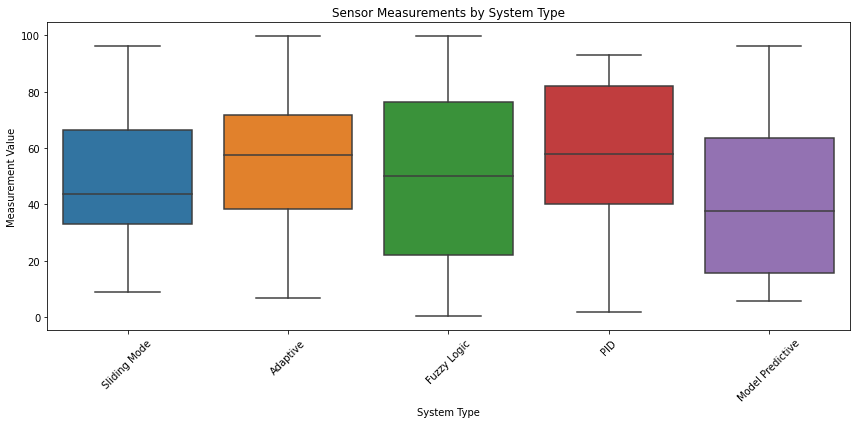

Summary Statistics for Sensor Measurements by System Type:
                  count       mean        std   min      25%     50%      75%  \
system_type                                                                     
Adaptive           18.0  54.232778  24.964496  6.96  38.5450  57.595  71.8675   
Fuzzy Logic        72.0  50.160556  29.924382  0.30  22.0800  50.130  76.2575   
Model Predictive   17.0  43.875882  32.508871  5.92  15.5600  37.860  63.4300   
PID                24.0  57.224583  27.144382  1.72  40.2075  58.080  81.9575   
Sliding Mode       19.0  49.401053  25.729090  8.92  33.1800  43.590  66.5500   

                    max  
system_type              
Adaptive          99.63  
Fuzzy Logic       99.64  
Model Predictive  96.18  
PID               93.00  
Sliding Mode      96.34  

ANOVA Test Results:
F-statistic: 0.6286200701477139, p-value: 0.6428395836791077


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def compare_measurements_by_system_type(systems_df, sensors_df, measurements_df):
    """
    Compare sensor measurements across different system types using boxplots and statistical analysis.

    This function joins the provided DataFrames to associate measurements with system types,
    creates a boxplot visualization, calculates summary statistics, and performs an ANOVA test
    to check for significant differences between system types.

    Parameters:
    systems_df (pd.DataFrame): DataFrame containing system information.
    sensors_df (pd.DataFrame): DataFrame containing sensor information.
    measurements_df (pd.DataFrame): DataFrame containing measurement data.

    Returns:
    None

    The function produces the following outputs:
    - A boxplot showing the distribution of sensor measurements by system type.
    - Printed summary statistics of measurements for each system type.
    """
    # Step 1: Join the DataFrames
    merged_df = measurements_df.merge(sensors_df, on='sensor_id', how='left') \
                                .merge(systems_df, on='system_id', how='left')

    # Step 2: Create boxplot for measurements by system type
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='system_type', y='value', data=merged_df)
    plt.title('Sensor Measurements by System Type')
    plt.xlabel('System Type')
    plt.ylabel('Measurement Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Step 3: Calculate summary statistics
    summary_stats = merged_df.groupby('system_type')['value'].describe()
    print("Summary Statistics for Sensor Measurements by System Type:")
    print(summary_stats)

    # Step 4: Perform ANOVA test
    anova_results = stats.f_oneway(
        *(merged_df[merged_df['system_type'] == st]['value'] for st in merged_df['system_type'].unique())
    )
    
    print("\nANOVA Test Results:")
    print(f"F-statistic: {anova_results.statistic}, p-value: {anova_results.pvalue}")

# Example usage
compare_measurements_by_system_type(systems_df, sensors_df, measurements_df)


In [18]:
def average_measurement_by_system_type(systems_df, sensors_df, measurements_df):
    """
    Calculate and print the average measurement value for each system type.

    This function joins the provided DataFrames to associate measurements with system types,
    calculates the average measurement value for each system type, and prints the results.

    Parameters:
    systems_df (pd.DataFrame): DataFrame containing system information.
    sensors_df (pd.DataFrame): DataFrame containing sensor information.
    measurements_df (pd.DataFrame): DataFrame containing measurement data.

    Returns:
    None

    The function prints the average measurement value for each system type,
    sorted in descending order.
    """
    # Step 1: Join the DataFrames
    merged_df = measurements_df.merge(sensors_df, on='sensor_id', how='left') \
                                .merge(systems_df, on='system_id', how='left')

    # Step 2: Calculate average measurement value for each system type
    average_values = merged_df.groupby('system_type')['value'].mean().reset_index()

    # Step 3: Sort the results in descending order
    average_values = average_values.sort_values(by='value', ascending=False)

    # Step 4: Print the results
    print("Average Measurement Value by System Type:")
    print(average_values)

# Example usage
average_measurement_by_system_type(systems_df, sensors_df, measurements_df)


Average Measurement Value by System Type:
        system_type      value
3               PID  57.224583
0          Adaptive  54.232778
1       Fuzzy Logic  50.160556
4      Sliding Mode  49.401053
2  Model Predictive  43.875882


In [19]:
def sensor_type_vs_control_action(systems_df, sensors_df, measurements_df, control_actions_df):
    """
    Calculate and print the average measurement value for each combination of sensor type and action type.

    This function performs multiple joins on the input DataFrames to associate measurements with sensor types and control actions.
    It then calculates the average measurement value for each combination of sensor type and action type.

    Parameters:
    systems_df (pd.DataFrame): DataFrame containing system information.
    sensors_df (pd.DataFrame): DataFrame containing sensor information.
    measurements_df (pd.DataFrame): DataFrame containing measurement data.
    control_actions_df (pd.DataFrame): DataFrame containing control action data.

    Returns:
    None

    The function prints intermediate results of the joins and the final average measurement values for each combination of sensor type and action type.
    """
    # Step 1: Join the DataFrames
    merged_df = measurements_df.merge(sensors_df, on='sensor_id', how='left') \
                                .merge(control_actions_df, on='system_id', how='left')

    # Step 2: Calculate average measurement value for each combination of sensor type and action type
    average_values = merged_df.groupby(['sensor_type', 'action_type'])['value'].mean().reset_index()

    # Step 3: Sort the results for better readability
    average_values = average_values.sort_values(by=['sensor_type', 'action_type'])

    # Step 4: Print the results
    print("Average Measurement Value by Sensor Type and Action Type:")
    print(average_values)

# Example usage
sensor_type_vs_control_action(systems_df, sensors_df, measurements_df, control_actions_df)


Average Measurement Value by Sensor Type and Action Type:
    sensor_type          action_type      value
0          Flow  Actuator Adjustment  55.690370
1          Flow      Alarm Triggered  48.043889
2          Flow      Setpoint Change  45.486053
3         Level  Actuator Adjustment  49.490000
4         Level      Alarm Triggered  57.328636
5         Level      Setpoint Change  56.528000
6      Pressure  Actuator Adjustment  49.823810
7      Pressure      Alarm Triggered  49.823810
8      Pressure      Setpoint Change  49.823810
9   Temperature  Actuator Adjustment  50.936533
10  Temperature      Alarm Triggered  50.500577
11  Temperature      Setpoint Change  50.515417


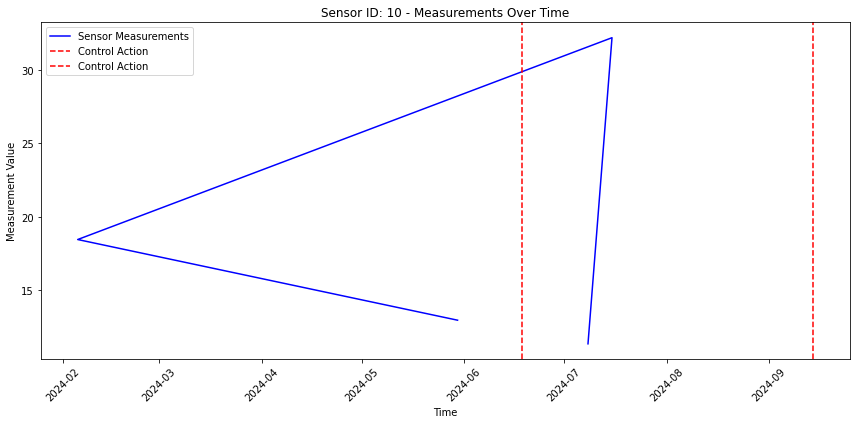

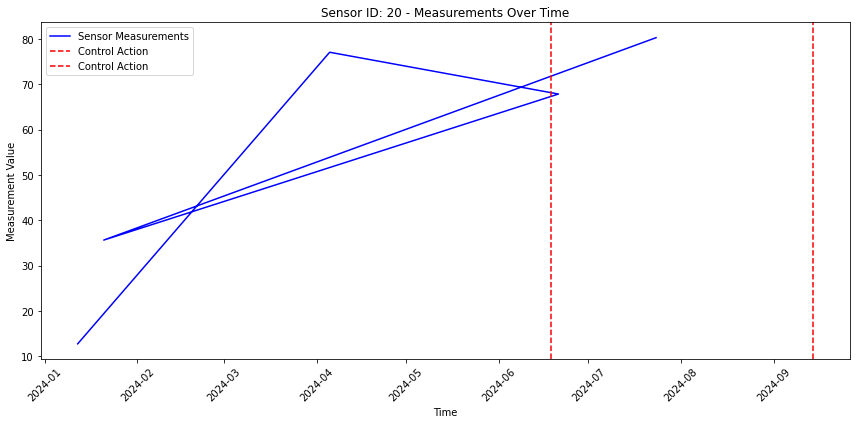

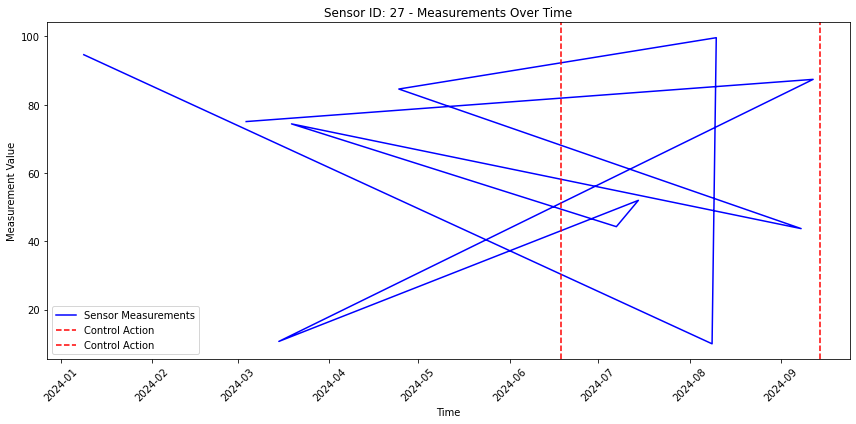

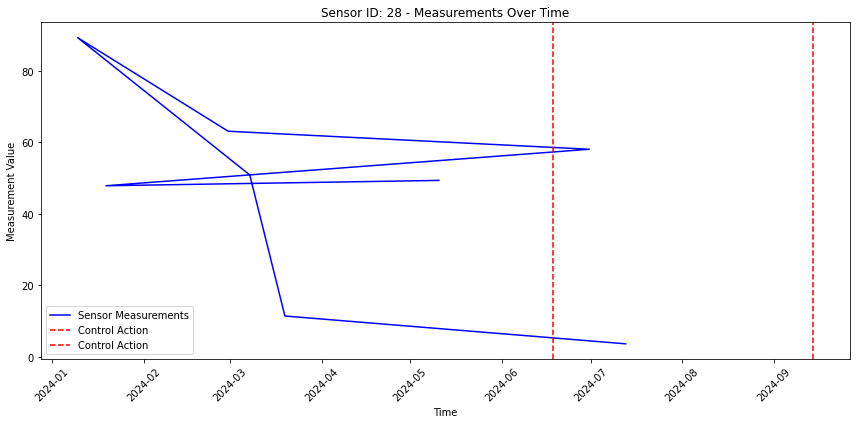

Sensor 10:
  Average change after control actions: 6.0750
  Number of control actions: 1
Sensor 20:
  Average change after control actions: 32.2583
  Number of control actions: 1
Sensor 27:
  Average change after control actions: -11.7030
  Number of control actions: 1
Sensor 28:
  Average change after control actions: -21.1367
  Number of control actions: 1


In [22]:
def analyze_control_action_impact(system_id, systems_df, sensors_df, measurements_df, control_actions_df):
    """
    Analyze the impact of control actions on sensor measurements for a given system.

    This function identifies all sensors and control actions for the specified system,
    plots sensor measurements over time with control action indicators,
    and calculates the average measurement value changes before and after each control action.

    Parameters:
    system_id (int): The ID of the system to analyze.
    systems_df (pd.DataFrame): DataFrame containing system information.
    sensors_df (pd.DataFrame): DataFrame containing sensor information.
    measurements_df (pd.DataFrame): DataFrame containing measurement data.
    control_actions_df (pd.DataFrame): DataFrame containing control action data.

    Returns:
    dict: A dictionary where keys are sensor IDs and values are dictionaries containing:
        - 'average_change': The average change in measurement value after control actions.
        - 'num_actions': The number of control actions for the sensor.

    The function also generates plots for each sensor, showing measurements over time and control action occurrences.
    """
    # Step 1: Identify all sensors for the given system
    system_sensors = sensors_df[sensors_df['system_id'] == system_id]

    # Step 2: Identify all control actions for the given system
    control_actions = control_actions_df[control_actions_df['system_id'] == system_id]

    # Initialize a summary dictionary
    impact_summary = {}

    # Step 3: Analyze each sensor
    for _, sensor in system_sensors.iterrows():
        sensor_id = sensor['sensor_id']
        
        # Get measurements for the sensor
        sensor_measurements = measurements_df[measurements_df['sensor_id'] == sensor_id]
        
        # Initialize average change and action count
        total_change = 0
        num_actions = 0

        # Plot measurements over time
        plt.figure(figsize=(12, 6))
        plt.plot(sensor_measurements['timestamp'], sensor_measurements['value'], label='Sensor Measurements', color='blue')

        # Step 4: Overlay control actions on the plot
        for _, action in control_actions.iterrows():
            action_time = action['timestamp']
            plt.axvline(action_time, color='red', linestyle='--', label='Control Action')

            # Calculate average measurement value before and after control action
            before_measurements = sensor_measurements[sensor_measurements['timestamp'] < action_time]['value']
            after_measurements = sensor_measurements[sensor_measurements['timestamp'] > action_time]['value']

            if not before_measurements.empty and not after_measurements.empty:
                average_before = before_measurements.mean()
                average_after = after_measurements.mean()
                
                # Update total change and action count
                total_change += (average_after - average_before)
                num_actions += 1

        # Finalize the plot
        plt.title(f'Sensor ID: {sensor_id} - Measurements Over Time')
        plt.xlabel('Time')
        plt.ylabel('Measurement Value')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Calculate average change
        average_change = total_change / num_actions if num_actions > 0 else 0
        impact_summary[sensor_id] = {
            'average_change': average_change,
            'num_actions': num_actions
        }

    return impact_summary

# Example usage:
system_id = 1  
impact_summary = analyze_control_action_impact(system_id, systems_df, sensors_df, measurements_df, control_actions_df)
for sensor_id, impact in impact_summary.items():
    print(f"Sensor {sensor_id}:")
    print(f"  Average change after control actions: {impact['average_change']:.4f}")
    print(f"  Number of control actions: {impact['num_actions']}")
